# Task 1: Investigate and analyze price data
### 1.Data Loading
The natural gas price data was loaded from the provided CSV file (`Nat_Gas.csv`), which contains monthly prices from **October 2020** to **September 2024**.

### 2.Data Visualization
A line plot was created to visualize historical natural gas prices, allowing for an understanding of trends and seasonal patterns.

### 3.Price Estimation
A function was implemented to estimate the price of natural gas for any given past date by finding the nearest available monthly price.

### 4.Price Extrapolation
Another function was created to extrapolate future prices for one year beyond the available data using a linear regression model based on historical trends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression


In [4]:
# Load data
data = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
data['Prices'] = data['Prices'].astype(float)


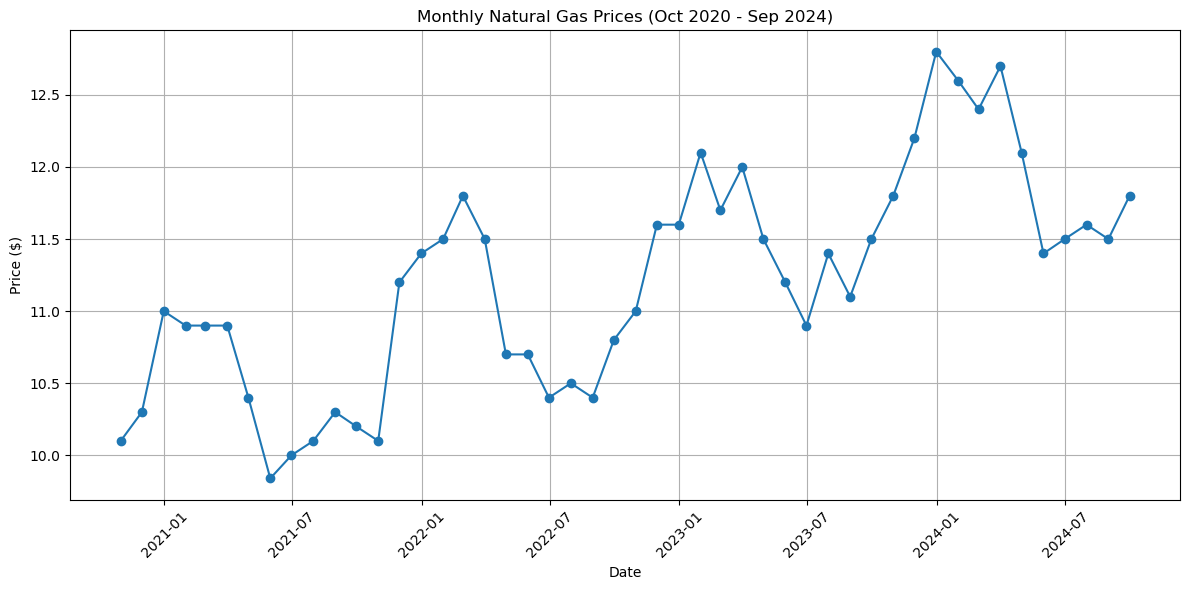

In [5]:
# Visualize historical prices
plt.figure(figsize=(12, 6))
plt.plot(data['Dates'], data['Prices'], marker='o')
plt.title('Monthly Natural Gas Prices (Oct 2020 - Sep 2024)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Function to estimate price for a given date
def estimate_price(date):
    # Interpolating prices for missing dates
    price_series = data.set_index('Dates').reindex(pd.date_range(start=data['Dates'].min(), end=data['Dates'].max(), freq='M')).interpolate()
    
    # Finding the closest available date in the price series
    closest_date = price_series.index[np.abs(price_series.index - date).argmin()]
    return price_series.loc[closest_date]['Prices']

# Function to extrapolate future prices for one year
def extrapolate_future_prices(start_date):
    # Prepare data for linear regression
    data['Date_Ordinal'] = data['Dates'].map(datetime.toordinal)
    X = data['Date_Ordinal'].values.reshape(-1, 1)
    y = data['Prices'].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predicting future dates
    future_dates = [start_date + timedelta(days=30 * i) for i in range(1, 13)]
    future_dates_ordinal = np.array([date.toordinal() for date in future_dates]).reshape(-1, 1)
    
    # Predict prices for future dates
    future_prices = model.predict(future_dates_ordinal)
    
    return dict(zip(future_dates, future_prices))

# Example usage
past_date = datetime(2022, 5, 15)  # Example past date
estimated_price = estimate_price(past_date)
print(f"Estimated price on {past_date.strftime('%Y-%m-%d')}: ${estimated_price:.2f}")

# Extrapolating prices from October 2024 onwards
start_extrapolation_date = datetime(2024, 10, 1)
future_prices = extrapolate_future_prices(start_extrapolation_date)

print("Extrapolated Prices for Next Year:")
for date, price in future_prices.items():
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

Estimated price on 2022-05-15: $10.70
Extrapolated Prices for Next Year:
2024-10-31: $12.16
2024-11-30: $12.20
2024-12-30: $12.24
2025-01-29: $12.28
2025-02-28: $12.32
2025-03-30: $12.36
2025-04-29: $12.40
2025-05-29: $12.43
2025-06-28: $12.47
2025-07-28: $12.51
2025-08-27: $12.55
2025-09-26: $12.59


# Task 2 : Price a commodity storage contract

### Function Definition
The `price_storage_contract` function calculates the total value of the storage contract based on cash flows from buying and selling natural gas. 

### Injections and Withdrawals
1. **Injections**:
   - For each injection date, the function checks if there is enough capacity to store additional gas. 
   - If capacity allows, it deducts the purchase cost from the total value and increases the current stored volume.
   - The function also calculates the storage costs incurred until the next withdrawal date.

2. **Withdrawals**:
   - For each withdrawal date, it verifies if there is sufficient stored gas available for withdrawal.
   - If there is enough gas, it adds to the total value based on the selling price of the gas.

## Summary of Coding Steps Performed
- **Data Loading**: The natural gas price data was loaded from a CSV file (`Nat_Gas.csv`), which contains monthly prices from October 2020 to September 2024.
- **Function Implementation**: Developed a function to handle the pricing logic for injections and withdrawals, incorporating storage costs and ensuring that capacity limits are respected.
- **Testing**: The function was tested with sample inputs to ensure accuracy in calculating the contract value.



In [11]:

from datetime import datetime


def price_storage_contract(injection_dates, withdrawal_dates, purchase_prices, sell_prices,
                           volume_per_injection, max_storage_volume, storage_costs):
    total_value = 0
    current_storage = 0
    
    # Calculate cash flows for injections
    for idx, injection_date in enumerate(injection_dates):
        if current_storage + volume_per_injection <= max_storage_volume:
            total_value -= purchase_prices[idx] * volume_per_injection  # Cost to buy gas
            current_storage += volume_per_injection  # Increase stored gas
            
            # Calculate storage costs until withdrawal
            months_until_withdrawal = [(wd - injection_date).days // 30 for wd in withdrawal_dates if wd > injection_date]
            if months_until_withdrawal:
                total_value -= storage_costs * min(months_until_withdrawal)  # Total storage cost

    # Calculate cash flows for withdrawals
    for idx, withdrawal_date in enumerate(withdrawal_dates):
        if current_storage >= volume_per_injection:
            total_value += sell_prices[idx] * volume_per_injection  # Revenue from selling gas
            current_storage -= volume_per_injection  # Decrease stored gas
    
    return total_value

# Example usage
injection_dates = [datetime(2024, 1, 1), datetime(2024, 2, 1)]
withdrawal_dates = [datetime(2024, 3, 1), datetime(2024, 4, 1)]
purchase_prices = [12.00, 12.10]  # Prices at which gas can be purchased
sell_prices = [12.50, 12.60]       # Prices at which gas can be sold
volume_per_injection = 1000000      # Volume in MMBtu
max_storage_volume = 3000000        # Max volume in MMBtu
storage_costs = 100000              # Monthly storage cost

contract_value = price_storage_contract(injection_dates, withdrawal_dates,
                                         purchase_prices, sell_prices,
                                         volume_per_injection,
                                         max_storage_volume,
                                         storage_costs)

print(f"The value of the storage contract is: ${contract_value:.2f}")

The value of the storage contract is: $800000.00
